Map saved as 'dc_metro_coverage_map.png'


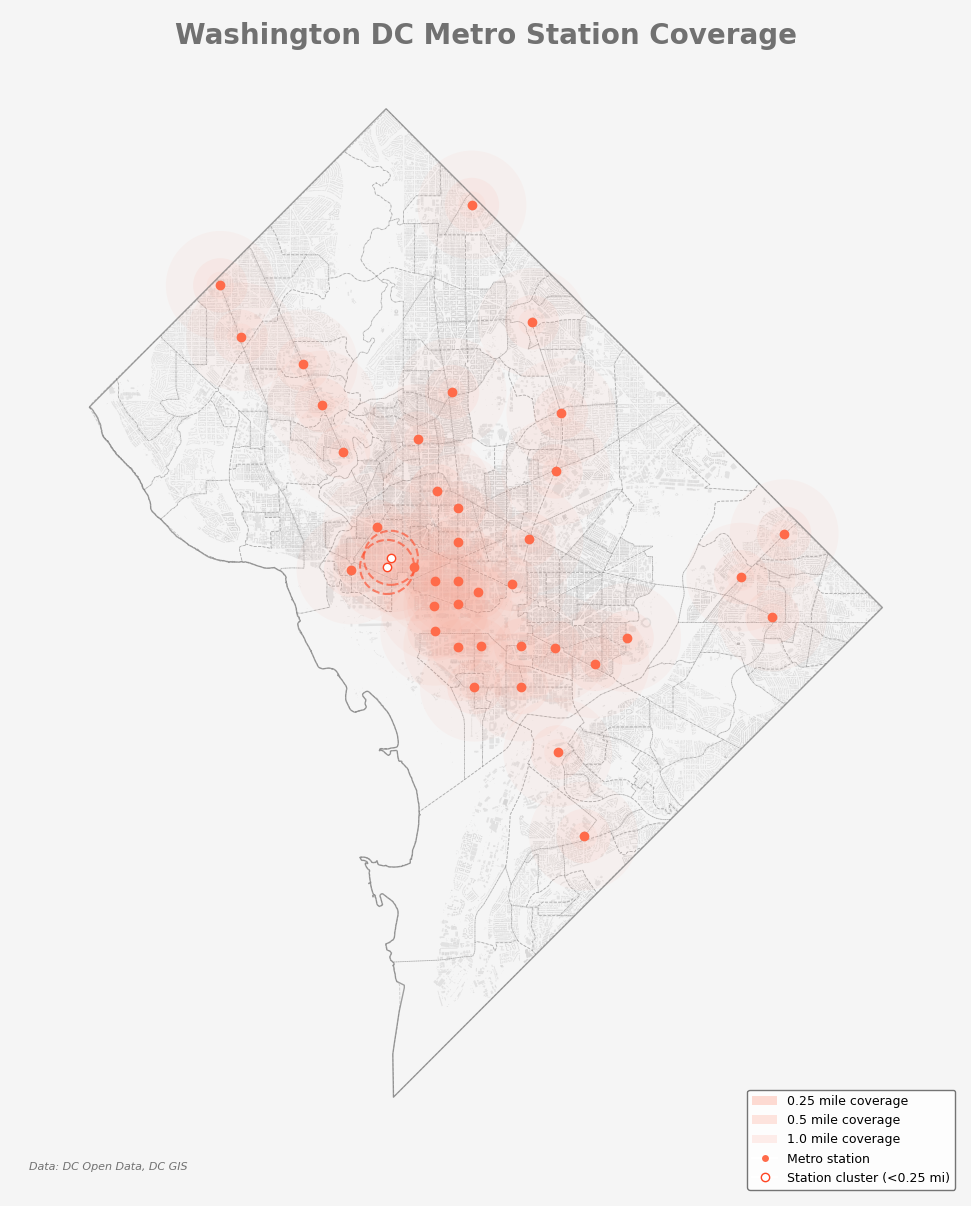

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch
import numpy as np
from shapely.geometry import Point
from scipy.spatial import distance_matrix
import warnings
warnings.filterwarnings('ignore')

# Load in data
dc_boundary = gpd.read_file("data/Washington_DC_boundary.geojson")
metro_stations = gpd.read_file('data/Metro_Stations_Regional.geojson')
buildings = gpd.read_file('data/Building_Footprints.geojson')
census_tracts_url = 'https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/Demographic_WebMercator/MapServer/8/query?outFields=*&where=1%3D1&f=geojson'
census_tracts = gpd.read_file(census_tracts_url)

# Filter metro stations ony in DC boundary
metro_stations = gpd.sjoin(metro_stations, dc_boundary, predicate='within')
metro_stations = metro_stations.drop(columns=['index_right'], errors='ignore')

# Convert CRS to match
dc_boundary = dc_boundary.to_crs(epsg=3857)
metro_stations = metro_stations.to_crs(epsg=3857)
buildings = buildings.to_crs(epsg=3857)
census_tracts = census_tracts.to_crs(epsg=3857)

# Create figure 
fig, ax = plt.subplots(figsize=(12, 12), facecolor='#f5f5f5')
ax.set_aspect('equal')
ax.axis('off')

# Add title
ax.text(0.5, 0.99, 'Washington DC Metro Station Coverage', 
        transform=ax.transAxes,
        fontsize=20,
        fontweight='bold',
        color='#666666EC',
        ha='center',
        va='top')

# Adjust map
plt.subplots_adjust(top=0.93)

# Plot boundaries and buildings
dc_boundary.boundary.plot(ax=ax, color="#666666EC", linewidth=1, alpha=0.6)
buildings.plot(ax=ax, color="#b9b8b8", edgecolor='#b9b8b8', linewidth=0.1, alpha=0.3, zorder=0.3)
census_tracts.boundary.plot(ax=ax, color="#666666EC", linewidth=0.6, alpha=0.3, zorder=0.5, linestyle='--')

# Add coverage circles around each station
radii = [1 * 1609.34, 0.5 * 1609.34, 0.25 * 1609.34]  # 1, 0.5, 0.25 miles
alphas = [0.05, 0.1, 0.15] 
colors = ['#ff8a70', '#ffa896', '#ffc7bc']

# Draw coverage circles for each station
for radius, alpha, color in zip(radii, alphas, colors):
    for idx, station in metro_stations.iterrows():
        circle = Circle(
            (station.geometry.x, station.geometry.y),
            radius,
            color=color,
            alpha=alpha,
            linewidth=0,
            zorder=1
        )
        ax.add_patch(circle)

# Get coordinates of all stations
coords = np.array([[station.geometry.x, station.geometry.y] 
                   for idx, station in metro_stations.iterrows()])

# Calculate distance matrix 
dist_matrix = distance_matrix(coords, coords)

# Find stations within 0.25 miles of another station
np.fill_diagonal(dist_matrix, np.inf)
emphasis_indices = set()
for i in range(len(dist_matrix)):
    if np.any(dist_matrix[i] <= 0.25 * 1609.34):
        # Use the actual DataFrame index, not the position
        emphasis_indices.add(metro_stations.index[i])

# Add dotted circles around stations within 0.25 miles of another station
for idx in emphasis_indices:
    station = metro_stations.loc[idx]
    circle = Circle(
        (station.geometry.x, station.geometry.y),
        800,
        color='#ff4422',
        fill=False,
        linestyle='--',
        linewidth=1.5,
        alpha=0.6,
        zorder=3
    )
    ax.add_patch(circle)

# Plot metro stations 
for idx, station in metro_stations.iterrows():
    if idx in emphasis_indices:
        # Hollow circle for emphasized stations
        ax.plot(station.geometry.x, station.geometry.y, 
               marker='o', markersize=6, 
               markerfacecolor='white', 
               markeredgecolor='#ff4422', 
               markeredgewidth=1,
               zorder=5)
    else:
        # Filled circle for regular stations
        ax.plot(station.geometry.x, station.geometry.y, 
               marker='o', markersize=6, 
               color='#ff6b4a',
               zorder=4)
        
# Make more room around the edges
bounds = dc_boundary.total_bounds  # [minx, miny, maxx, maxy]
x_range = bounds[2] - bounds[0]
y_range = bounds[3] - bounds[1]

padding = 0.1
ax.set_xlim(bounds[0] - x_range * padding, bounds[2] + x_range * padding)
ax.set_ylim(bounds[1] - y_range * padding, bounds[3] + y_range * padding)

# Create legend
legend_elements = [
    Patch(facecolor='#ff8a70', alpha=0.3, label='0.25 mile coverage'),
    Patch(facecolor='#ffa896', alpha=0.3, label='0.5 mile coverage'),
    Patch(facecolor='#ffc7bc', alpha=0.3, label='1.0 mile coverage'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff6b4a', 
               markersize=6, label='Metro station'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='white', 
               markeredgecolor='#ff4422', markeredgewidth=1, markersize=6, 
               label='Station cluster (<0.25 mi)')
]

ax.legend(handles=legend_elements, loc='lower right', 
         frameon=True, facecolor='white', edgecolor='#666666EC',
         fontsize=9, framealpha=0.9)

# Add data source note
ax.text(0.02, 0.02, 'Data: DC Open Data, DC GIS', 
        transform=ax.transAxes,
        fontsize=8,
        color='#666666EC',
        ha='left',
        va='bottom',
        style='italic')


# Map aesthetics
ax.set_facecolor("#e3e1e1")
fig.patch.set_facecolor('#f5f5f5')

plt.tight_layout(pad=0.5)

# Save the figure
plt.savefig('dc_metro_coverage_map.png', dpi=300, bbox_inches='tight', 
            facecolor='#f5f5f5')

# Display the map
plt.show()